In [ ]:
!pip install -q evaluate
!pip install -q rouge_score
!pip install -q loralib
!pip install -q datasets
!pip install -q bitsandbytes
!pip install -q transformers
!pip install -q einops accelerate bitsandbytes
!pip install -q sentence_transformers
!pip install -q git+https://github.com/huggingface/peft.git

In [ ]:
import json
import os

import pandas as pd
import torch
from datasets import load_dataset, Dataset
from evaluate import load
from google.colab import drive, userdata
from huggingface_hub import login
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    T5Tokenizer,
    T5Model,
    T5ForConditionalGeneration,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)

In [ ]:
metric = load("rouge")

In [ ]:
from google.colab import drive, userdata
drive.mount('/content/drive')

In [ ]:
login(userdata.get('huggingface_token'))

## Carregando dados para fine-tuning



In [ ]:
import pandas as pd
from google.colab import drive, userdata

In [ ]:
drive.mount('/content/drive')

In [ ]:
save_path = "/content/drive/MyDrive/Estudos/Poli/TCC/notebooks/"
docs_df = pd.read_csv(save_path + "2_summaries_dataset.csv", index_col=0, usecols=[1, 2, 3])

In [ ]:
df_train, df_val = train_test_split(docs_df, shuffle=True, random_state=42, test_size=0.15)
print(df_train.shape)
print(df_val.shape)

(60, 2)
(11, 2)


In [ ]:
df_train.head()

,source_text,target_summary
published_title,,
100-2023-VNC-Comunicado Externo,"Informamos que, em 30/10/2023, será implementa...","Informamos que, em 30/10/2023, será implementa..."
104-2023-PRE-Ofício Circular,"Informamos que, em 30/06/2023, entrará em vigo...","Informamos que, em 30/06/2023, entrará em vigo..."
104-2023-VNC-Comunicado Externo,"A B3 informa que, a partir do dia 08/11/2023, ...","A B3 informa que, a partir do dia 08/11/2023, ..."
036-2023-VPC-Comunicado Externo,"Informamos que, nos dias 22 e 29/07/2023, será...","Informamos que, nos dias 22 e 29/07/2023, será..."
079-2023-VNC-Comunicado Externo,Conforme divulgado no item 4.3.3.1 do Manual d...,Conforme divulgado no item 4.3.3.1 do Manual d...


In [ ]:
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_val)
train_dataset

Dataset({
    features: ['source_text', 'target_summary', 'published_title'],
    num_rows: 60
})

## Carregando modelo

In [ ]:
llm_model = "unicamp-dl/ptt5-base-portuguese-vocab"
tokenizer = AutoTokenizer.from_pretrained(llm_model, cache_dir=save_path + "cache")
model = AutoModelForSeq2SeqLM.from_pretrained(llm_model, cache_dir=save_path + "cache")

In [ ]:
model.eval()

In [ ]:
max_input_length = 1024
max_target_length = 256
prefix = "summarize: "

def preprocess_function(examples):
    inputs = prefix + examples["source_text"]
    model_inputs = tokenizer(inputs, truncation=True, padding="max_length")

    # Setup do tokenizador
    labels = tokenizer(text_target=examples["target_summary"], truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
proc_train = train_dataset.map(preprocess_function)
proc_val = train_dataset.map(preprocess_function)
proc_train

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Dataset({
    features: ['source_text', 'target_summary', 'published_title', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 60
})

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
from transformers import Adafactor, get_cosine_schedule_with_warmup

epochs = 100
batch_size = 4
learning_rate = 2e-5
warmup_steps = 50

total_steps = round(len(train_dataset) / batch_size) * epochs
save_steps = total_steps // 5
beta1 = 0.9

optimizer = Adafactor(
    model.parameters(),
    lr=learning_rate,
    beta1=beta1,
    weight_decay=0,
    scale_parameter=True,
    relative_step=False
)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps,
)



args = Seq2SeqTrainingArguments(
    f"b3-summ-ptt5-base-portuguese-vocab",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.0,
    save_total_limit=9,
    save_steps=save_steps,
    evaluation_strategy="steps",
    eval_steps=save_steps,
    num_train_epochs=epochs,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
)

In [ ]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # Note that other metrics may not have a `use_aggregator` parameter
    # and thus will return a list, computing a metric for each sentence.
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True, use_aggregator=True)
    # Extract a few results
    result = {key: value * 100 for key, value in result.items()}

    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=proc_train,
    eval_dataset=proc_val,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler),
)

In [ ]:
trainer.train()

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
300,No log,0.160854,17.975800,16.723800,17.950500,17.964100,19.000000
600,0.388200,0.057733,19.390200,18.067800,19.337200,19.375200,19.000000
900,0.388200,0.041252,19.490900,18.215600,19.450100,19.493800,19.000000
1200,0.067100,0.035799,19.707800,18.554500,19.735600,19.748700,19.000000
1500,0.053100,0.035048,19.915500,18.790700,19.932400,19.952900,19.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control

TrainOutput(global_step=1500, training_loss=0.16945480600992838, metrics={'train_runtime': 873.5917, 'train_samples_per_second': 6.868, 'train_steps_per_second': 1.717, 'total_flos': 3260151216783360.0, 'train_loss': 0.16945480600992838, 'epoch': 100.0})

In [ ]:
trainer.push_to_hub()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

events.out.tfevents.1704676305.3a9c5c093f41.790.0:   0%|          | 0.00/7.98k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gbieul/b3-summ-ptt5-base-portuguese-vocab/commit/34822b3109ef643dbfc7bece7dfcea14ae47df0f', commit_message='End of training', commit_description='', oid='34822b3109ef643dbfc7bece7dfcea14ae47df0f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("gbieul/b3-summ-ptt5-base-portuguese-vocab")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/gbieul/b3-summ-ptt5-base-portuguese-vocab/commit/1f0bfcbe361a9cdbf4d21e65014ebb8aa513406f', commit_message='Upload tokenizer', commit_description='', oid='1f0bfcbe361a9cdbf4d21e65014ebb8aa513406f', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model.push_to_hub("gbieul/b3-summ-ptt5-base-portuguese-vocab")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/gbieul/b3-summ-ptt5-base-portuguese-vocab/commit/9b386925ae33d1f1e52ad09ca7a5947b4d1f3749', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='9b386925ae33d1f1e52ad09ca7a5947b4d1f3749', pr_url=None, pr_revision=None, pr_num=None)

## Geração

In [ ]:
from tqdm import tqdm

In [ ]:
tqdm.pandas()

In [ ]:
def generate_predictions(input):
  prefix = "summarize: "

  tokenized = tokenizer(prefix + input, return_tensors="pt")
  input_ids = tokenized.input_ids.cuda()
  mask = tokenized.attention_mask.cuda()

  outputs = model.generate(input_ids=input_ids,
                         attention_mask=mask,
                         max_length=256,
                         num_beams=2,
                         repetition_penalty=2.5,
                         length_penalty=-5.0,
                         early_stopping=True
                         )

  return (
      tokenizer
      .decode(
          outputs[0],
          skip_special_tokens=True,
          clean_up_tokenization_spaces=True
      )
  )

In [ ]:
docs_df["generated_summary"] = docs_df["source_text"].progress_apply(generate_predictions)

100%|██████████| 71/71 [05:04<00:00,  4.30s/it]


In [ ]:
docs_df["rouge_scores"] = docs_df.progress_apply(lambda row: metric.compute(predictions=[row["generated_summary"]], references=[row["target_summary"]]), axis=1)

100%|██████████| 71/71 [00:19<00:00,  3.63it/s]


In [ ]:
scores = docs_df["rouge_scores"].apply(pd.Series)
docs_with_rouge = docs_df.drop(columns="rouge_scores").merge(scores, left_index=True, right_index=True)

In [ ]:
docs_with_rouge.to_csv(save_path + "3_t5_summaries_generation")

<Axes: >

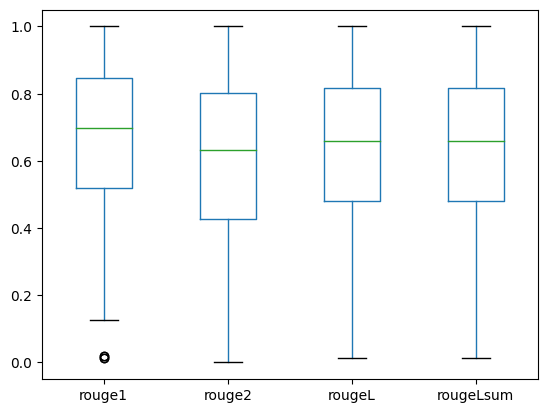

In [ ]:
docs_with_rouge[["rouge1", "rouge2",	"rougeL", "rougeLsum"]].boxplot(grid=False)


In [ ]:
import textwrap
import pandas as pd

In [ ]:
save_path = "/content/drive/MyDrive/Estudos/Poli/TCC/notebooks/"
docs_with_rouge = pd.read_csv(save_path + "3_t5_summaries_generation", index_col=0)
docs_with_rouge.head()

,source_text,target_summary,generated_summary,rouge1,rouge2,rougeL,rougeLsum
published_title,,,,,,,
187-2023-PRE-Ofício Circular,"Informamos que, a partir de 13/11/2023, inclus...","Informamos que, a partir de 13/11/2023, inclus...","Informamos que, a partir de 13/11/2023, inclus...",0.605128,0.569948,0.594872,0.594872
107-2023-VNC-Comunicado Externo,"A B3 informa que, conforme Comunicado Externo ...","A B3 informa que, conforme Comunicado Externo ...","A B3 informa que, conforme Comunicado Externo ...",0.641667,0.638655,0.641667,0.641667
059-2023-VPC-Comunicado Externo,"A B3 informa que, no dia 13/11/2023, atualizar...","A B3 informa que, no dia 13/11/2023, atualizar...","A B3 informa que, no dia 13/11/2023, atualizar...",0.693182,0.643678,0.659091,0.659091
186-2023-PRE-Ofício Circular,"Informamos que, a partir de 27/11/2023, serão ...","Informamos que, a partir de 27/11/2023, serão ...","Informamos que, a partir de 27/11/2023, serão ...",0.750000,0.653061,0.722973,0.722973
184-2023-PRE-Ofício Circular,"Informamos que, em 21/11/2023, entrarão em vig...","Informamos que, em 21/11/2023, entrarão em vig...","Informamos que, em 21/11/2023, entrarão em vig...",0.696429,0.604790,0.666667,0.666667


In [ ]:
for title, row in docs_with_rouge.head(10).iterrows():
  print(title)
  print(f"Scores: 'rouge1' {row['rouge1']: .2f} | 'rouge2' {row['rouge2']: .2f} | 'rougeL' {row['rougeL']: .2f} | 'rougeLsum' {row['rougeLsum']: .2f}")
  print("###### Original")
  print(textwrap.fill(row["source_text"], 70), "\n\n")
  print("###### Resumo referência")
  print(textwrap.fill(row["target_summary"], 70))
  print("###### Resumo gerado")
  print(textwrap.fill(row["generated_summary"], 70))
  print("\n\n\n")

187-2023-PRE-Ofício Circular
Scores: 'rouge1'  0.61 | 'rouge2'  0.57 | 'rougeL'  0.59 | 'rougeLsum'  0.59
###### Original
Informamos que, a partir de 13/11/2023, inclusive, será alterada a
regra para cadastro automático de vencimentos do Contrato Futuro de
Cupom de IPCA (DAP). A regra de cadastro automático de vencimentos foi
revista, visando ampliar a abertura de novos vencimentos curtos de
DAP, de 3 primeiros meses para 6, conforme tabela abaixo. Regra até
10/11/2023. Regra a partir de 13/11/2023. A regra vigente de cadastro
automático e cadastro pré-aprovado de instrumentos para o DAP pode ser
consultada em Regulação, Estrutura normativa, Regulamentos e manuais,
Negociação, Acessar documentos, Critérios para Criação e Exclusão de
Vencimentos Futuros e Séries de Opções. Ressaltamos que os demais
termos do Contrato Futuro de Cupom de IPCA (DAP) permanecem
inalterados. O único ajuste é referente ao cadastro automático. 


###### Resumo referência
Informamos que, a partir de 13/11/2023,